In [174]:
import math
import os
import numpy as np
import pandas as pd
from collections import OrderedDict
import torch
import gpytorch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import datetime 
from sklearn.model_selection import train_test_split

import pickle


# File collection
#### Model 1 data setup: all previous days
note: model performance should increase

In [208]:
m1_daily_chains = OrderedDict()
files = os.listdir('../option_data/spy_data')[1:]
files.sort(key=lambda x: x[-14:-4])

for file in files:
    
    if file[-4:] == '.csv':
    
        df = pd.read_csv('../option_data/spy_data/' + file)        
        
        # moving to datetime and making features
        df['quote_datetime'] = pd.to_datetime(df['quote_datetime'])
        df['expiration'] = pd.to_datetime(df['expiration'])
        df['quote_date'] = df['quote_datetime'][0].date()
        df['quote_date'] = pd.to_datetime(df['quote_date'])
        
        # getting only 4:00 quotes
        eod = datetime.datetime.combine(df['quote_datetime'][0].date(), datetime.time(16,0, 0))
        df = df.loc[df['quote_datetime'] == eod]
        
        # getting time to expiration and moneyness and time
        df['T'] = df['expiration'] - df['quote_date']
        df['T'] = df['T'].dt.days
        df['moneyness'] = df['active_underlying_price'] / df['strike'] 
        df['relative_time'] = 0
                
        # converting to ML features
        df['T'] = df['T'].astype(np.float32)
        df['mny'] = df['moneyness'].astype(np.float32)
        df['iv'] = df['implied_volatility'].astype(np.float32)
        df['rT'] = df['relative_time'].astype(np.float32)
        
        # filtering for research paper criteria
        df = df.loc[(df['close']!=0) & (df['iv']!=0) & (df['T']>=20) & (df['T']<=365) & (df['mny']>0.7) & (df['mny']<1.3)]
                
        # splitting up into calls/puts
        calls = df.loc[df['option_type']=='C'][['T', 'mny', 'rT', 'iv']]
        puts = df.loc[df['option_type']=='P'][['T', 'mny', 'rT', 'iv']]
        
        ttm = df['T'].unique().tolist()

                
        c_copies = [calls]
        p_copies = [puts]
        
        
        if m1_daily_chains:
            
            opt = m1_daily_chains[next(reversed(m1_daily_chains))]
            c_copy = opt['calls'].copy()
            p_copy = opt['puts'].copy()
            c_copy['rT'] = c_copy['rT'] + 1
            p_copy['rT'] = p_copy['rT'] + 1
            
            c_copies.append(c_copy)
            p_copies.append(p_copy)
                    
        calls = pd.concat(c_copies, axis=0, ignore_index=True)
        puts = pd.concat(p_copies, axis=0, ignore_index=True)
        
        opts = {'calls':calls, 'puts':puts, 'ttm':ttm}

        # assinging to date
        m1_daily_chains[file[-14:-4]] = opts 
    

#### Model 2 data setup: previous $k$ days
note: emit first day, model performance should stay similar

In [216]:
m2_daily_chains = OrderedDict()
files = os.listdir('../option_data/spy_data')[1:]
files.sort(key=lambda x: x[-14:-4])

# EDIT AS NECESSARY
k = 1

for file in files:
    
    if file[-4:] == '.csv':
    
        df = pd.read_csv('../option_data/spy_data/' + file)        
        
        # moving to datetime and making features
        df['quote_datetime'] = pd.to_datetime(df['quote_datetime'])
        df['expiration'] = pd.to_datetime(df['expiration'])
        df['quote_date'] = df['quote_datetime'][0].date()
        df['quote_date'] = pd.to_datetime(df['quote_date'])
        
        # getting only 4:00 quotes
        eod = datetime.datetime.combine(df['quote_datetime'][0].date(), datetime.time(16,0, 0))
        df = df.loc[df['quote_datetime'] == eod]
        
        # getting time to expiration and moneyness and time
        df['T'] = df['expiration'] - df['quote_date']
        df['T'] = df['T'].dt.days
        df['moneyness'] = df['active_underlying_price'] / df['strike'] 
        df['relative_time'] = 0
                
        # converting to ML features
        df['T'] = df['T'].astype(np.float32)
        df['mny'] = df['moneyness'].astype(np.float32)
        df['iv'] = df['implied_volatility'].astype(np.float32)
        df['rT'] = df['relative_time'].astype(np.float32)
        
        # filtering for research paper criteria
        df = df.loc[(df['close']!=0) & (df['iv']!=0) & (df['T']>=20) & (df['T']<=365) & (df['mny']>0.7) & (df['mny']<1.3)]
                
        # splitting up into calls/puts
        calls = df.loc[df['option_type']=='C'][['T', 'mny', 'rT', 'iv']]
        puts = df.loc[df['option_type']=='P'][['T', 'mny', 'rT', 'iv']]
        
        ttm = df['T'].unique().tolist()

        c_copies = [calls]
        p_copies = [puts]
        
        
        if m2_daily_chains:
            
            opt = m2_daily_chains[next(reversed(m2_daily_chains))]
            c_copy = opt['calls'].copy()
            p_copy = opt['puts'].copy()
            
            # last k will be 0 to -(k-1)
            # k=2: rT= 0 or 1 for previous daily chain
            c_copy = c_copy[(c_copy['rT'].isin(range(0, k)))]
            p_copy = p_copy[(p_copy['rT'].isin(range(0, k)))]
            c_copy['rT'] = c_copy['rT'] + 1
            p_copy['rT'] = p_copy['rT'] + 1
            
            c_copies.append(c_copy)
            p_copies.append(p_copy)
                    
        calls = pd.concat(c_copies, axis=0, ignore_index=True)
        puts = pd.concat(p_copies, axis=0, ignore_index=True)
        
        opts = {'calls':calls, 'puts':puts, 'ttm':ttm}

        # assinging to date
        m2_daily_chains[file[-14:-4]] = opts 
        
# drop first element entered
_ = m2_daily_chains.popitem(last=False)
    

#### Model 3: regular data setup

In [217]:
m3_daily_chains = OrderedDict()
files = os.listdir('../option_data/spy_data')[1:]
files.sort(key=lambda x: x[-14:-4])

for file in files:
    
    if file[-4:] == '.csv':
    
        df = pd.read_csv('../option_data/spy_data/' + file)        
        
        # moving to datetime and making features
        df['quote_datetime'] = pd.to_datetime(df['quote_datetime'])
        df['expiration'] = pd.to_datetime(df['expiration'])
        df['quote_date'] = df['quote_datetime'][0].date()
        df['quote_date'] = pd.to_datetime(df['quote_date'])
        
        # getting only 4:00 quotes
        eod = datetime.datetime.combine(df['quote_datetime'][0].date(), datetime.time(16,0, 0))
        df = df.loc[df['quote_datetime'] == eod]
        
        # getting time to expiration and moneyness and time
        df['T'] = df['expiration'] - df['quote_date']
        df['T'] = df['T'].dt.days
        df['moneyness'] = df['active_underlying_price'] / df['strike'] 
        df['relative_time'] = 0
                
        # converting to ML features
        df['T'] = df['T'].astype(np.float32)
        df['mny'] = df['moneyness'].astype(np.float32)
        df['iv'] = df['implied_volatility'].astype(np.float32)
        df['rT'] = df['relative_time'].astype(np.float32)
        
        # filtering for research paper criteria
        df = df.loc[(df['close']!=0) & (df['iv']!=0) & (df['T']>=20) & (df['T']<=365) & (df['mny']>0.7) & (df['mny']<1.3)]
                
        # splitting up into calls/puts
        calls = df.loc[df['option_type']=='C'][['T', 'mny', 'rT', 'iv']]
        puts = df.loc[df['option_type']=='P'][['T', 'mny', 'rT', 'iv']]
        
        ttm = df['T'].unique().tolist()

        opts = {'calls':calls, 'puts':puts, 'ttm':ttm}

        # assinging to date
        m3_daily_chains[file[-14:-4]] = opts 
            

# GP Models
#### Approximate GP Model: SVGP

In [218]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy

class SVGPModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super(SVGPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

#### Natural Gradient Descent GP Model:

In [219]:
class NGD_GPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.NaturalVariationalDistribution(inducing_points.size(0))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super(NGD_GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

#### Exact GP Model:

In [220]:
# exact inference for smaller datasets?
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### Model 1: Training on all available past days, evaluating on present. 
Using NGD approach for faster convergence.

In [240]:
TGP_model1 = OrderedDict()

for day, options in list(m1_daily_chains.items()):
    
    info = {}
    
    # calls and puts
    c = options['calls']
    p = options['puts']
    
    # feature transformations
    c['mm_T'] = (c['T'] - 20)/(365-20)
    c['mm_mny'] = (c['mny'] - 0.7)/(1.3-0.7)
    c['ln_iv'] = np.log(c['iv'])

    p['mm_T'] = (p['T'] - 20)/(365-20)
    p['mm_mny'] = (p['mny'] - 0.7)/(1.3-0.7)
    p['ln_iv'] = np.log(p['iv'])
    
    # test/train split
    c_train, c_test = train_test_split(c, test_size=0.2)
    p_train, p_test = train_test_split(p, test_size=0.2)
    info['call_train'] = c_train
    info['call_test'] = c_test
    info['put_train'] = p_train
    info['put_test'] = p_test
    
    # into tensors and a dataloader
    cx_train = torch.tensor(c_train[['mm_T', 'mm_mny', 'rT']].values)
    cy_train = torch.tensor(c_train[['ln_iv']].values).reshape(len(c_train))
    cx_test = torch.tensor(c_test[['mm_T', 'mm_mny', 'rT']].values)
    cy_test = torch.tensor(c_test[['ln_iv']].values).reshape(len(c_test))
    c_dataset = TensorDataset(cx_train, cy_train)
    c_loader = DataLoader(c_dataset, batch_size=1024, shuffle=True)

    px_train = torch.tensor(p_train[['mm_T', 'mm_mny', 'rT']].values)
    py_train = torch.tensor(p_train[['ln_iv']].values).reshape(len(p_train))
    px_test = torch.tensor(p_test[['mm_T', 'mm_mny', 'rT']].values)
    py_test = torch.tensor(p_test[['ln_iv']].values).reshape(len(p_test))
    p_dataset = TensorDataset(px_train, py_train)
    p_loader = DataLoader(p_dataset, batch_size=1024, shuffle=True)
    
    #break
        
    c_inducing_points = cx_train[:512, :]
    p_inducing_points = px_train[:512, :]
    
    c_model = NGD_GPModel(inducing_points=c_inducing_points)
    c_likelihood = gpytorch.likelihoods.GaussianLikelihood()
    
    p_model = NGD_GPModel(inducing_points=p_inducing_points)
    p_likelihood = gpytorch.likelihoods.GaussianLikelihood()
        
    # Use the ngd optimizer for parameters, adam for hyperparameters and ll 
    c_ngd_optimizer = gpytorch.optim.NGD(c_model.variational_parameters(), num_data=cy_train.size(0), lr=0.1)
    c_hyper_optimizer= torch.optim.Adam([
        {'params': c_model.hyperparameters()},
        {'params': c_likelihood.parameters()},
    ], lr=0.01) 
    
    p_ngd_optimizer = gpytorch.optim.NGD(p_model.variational_parameters(), num_data=py_train.size(0), lr=0.1)
    p_hyper_optimizer = torch.optim.Adam([
        {'params': p_model.hyperparameters()},
        {'params': p_likelihood.parameters()},
    ], lr=0.01)
    
    # train mode
    c_model.train()
    c_likelihood.train()

    p_model.train()
    p_likelihood.train()
    
    
    # Loss for variational GPs - ELBO
    c_mll = gpytorch.mlls.VariationalELBO(c_likelihood, c_model, num_data=cy_train.size(0))
    p_mll = gpytorch.mlls.VariationalELBO(p_likelihood, p_model, num_data=py_train.size(0))

    c_losses = []
    p_losses = []    
        
    training_iter = 1000
    print('STARTING CALL GP TRAINING FOR ', day)
    for i in range(training_iter):
        # Within each iteration, we go over each minibatch
        for x_batch, y_batch in c_loader:
            
            # NGS on variational params
            c_ngd_optimizer.zero_grad()
            c_output = c_model(x_batch)
            c_loss = -c_mll(c_output, y_batch)
            c_loss.backward()
            c_ngd_optimizer.step()

            # Adam step on hyperparameters
            c_hyper_optimizer.zero_grad()
            c_output = c_model(x_batch)
            c_loss = -c_mll(c_output, y_batch)
            c_loss.backward()
            c_hyper_optimizer.step()
            
        c_losses.append(c_loss.item())

        
    print('STARTING PUT GP TRAINING FOR ', day)
    for i in range(training_iter):
        # Go through each minibatch:
        for x_batch, y_batch in p_loader:
            
            # PERFORMING NGD
            p_ngd_optimizer.zero_grad()
            p_hyper_optimizer.zero_grad()
            
            # Output from model
            p_output = p_model(x_batch)
            # Calc loss and backprop gradients
            p_loss = -p_mll(p_output, y_batch)
            p_loss.backward()
            
            p_ngd_optimizer.step()
            p_hyper_optimizer.step()
            
        p_losses.append(p_loss.item())

    
    info['call_losses'] = c_losses
    info['put_losses'] = p_losses

    # Get into evaluation (predictive posterior) mode
    c_model.eval()
    c_likelihood.eval()
    
    p_model.eval()
    p_likelihood.eval()

    # Make predictions:
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        c_preds = c_likelihood(c_model(cx_test))
        p_preds = p_likelihood(p_model(px_test))

    info['call_preds'] = c_preds
    info['put_preds'] = p_preds        

    # rmse ONLY ON LAST DAY
    c_ind = cx_test[:, 2]==0
    p_ind = px_test[:, 2]==0
    c_rmse = torch.sqrt(torch.mean(torch.pow(math.e ** c_preds.mean[c_ind] - math.e ** cy_test[c_ind], 2)))
    p_rmse = torch.sqrt(torch.mean(torch.pow(math.e ** p_preds.mean[p_ind] - math.e ** py_test[p_ind], 2)))
    info['call_RMSE'] = c_rmse
    info['put_RMSE'] = p_rmse
    
    # saving the model
    torch.save(c_model, 'models/TGP1_call_'+day+'.pt')
    torch.save(p_model, 'models/TGP1_put_'+day+'.pt')
    
    # saving likelihood
    info['call_likelihood'] = c_likelihood
    info['put_likelihood'] = p_likelihood
    
    TGP_model1[day] = info 
    

with open('pickles/model1_info.pickle', 'wb') as handle:
    pickle.dump(TGP_model1, handle, protocol=pickle.HIGHEST_PROTOCOL)
         

STARTING CALL GP TRAINING FOR  2023-10-02
STARTING PUT GP TRAINING FOR  2023-10-02
STARTING CALL GP TRAINING FOR  2023-10-03
STARTING PUT GP TRAINING FOR  2023-10-03
STARTING CALL GP TRAINING FOR  2023-10-04
STARTING PUT GP TRAINING FOR  2023-10-04
STARTING CALL GP TRAINING FOR  2023-10-05
STARTING PUT GP TRAINING FOR  2023-10-05
STARTING CALL GP TRAINING FOR  2023-10-06
STARTING PUT GP TRAINING FOR  2023-10-06
STARTING CALL GP TRAINING FOR  2023-10-09
STARTING PUT GP TRAINING FOR  2023-10-09
STARTING CALL GP TRAINING FOR  2023-10-10
STARTING PUT GP TRAINING FOR  2023-10-10
STARTING CALL GP TRAINING FOR  2023-10-11
STARTING PUT GP TRAINING FOR  2023-10-11
STARTING CALL GP TRAINING FOR  2023-10-12
STARTING PUT GP TRAINING FOR  2023-10-12
STARTING CALL GP TRAINING FOR  2023-10-13
STARTING PUT GP TRAINING FOR  2023-10-13
STARTING CALL GP TRAINING FOR  2023-10-16
STARTING PUT GP TRAINING FOR  2023-10-16
STARTING CALL GP TRAINING FOR  2023-10-17
STARTING PUT GP TRAINING FOR  2023-10-17
STAR

### Model 2: Training on last $k$ days - we can use exact model?

In [241]:
TGP_model2 = OrderedDict()
exact = False

for day, options in list(m2_daily_chains.items()):
    
    info = {}
    
    # calls and puts
    c = options['calls']
    p = options['puts']
    
    # feature transformations
    c['mm_T'] = (c['T'] - 20)/(365-20)
    c['mm_mny'] = (c['mny'] - 0.7)/(1.3-0.7)
    c['ln_iv'] = np.log(c['iv'])

    p['mm_T'] = (p['T'] - 20)/(365-20)
    p['mm_mny'] = (p['mny'] - 0.7)/(1.3-0.7)
    p['ln_iv'] = np.log(p['iv'])
    
    # test/train split
    c_train, c_test = train_test_split(c, test_size=0.2)
    p_train, p_test = train_test_split(p, test_size=0.2)
    info['call_train'] = c_train
    info['call_test'] = c_test
    info['put_train'] = p_train
    info['put_test'] = p_test
    
    # into tensors and a dataloader
    cx_train = torch.tensor(c_train[['mm_T', 'mm_mny', 'rT']].values)
    cy_train = torch.tensor(c_train[['ln_iv']].values).reshape(len(c_train))
    cx_test = torch.tensor(c_test[['mm_T', 'mm_mny', 'rT']].values)
    cy_test = torch.tensor(c_test[['ln_iv']].values).reshape(len(c_test))
    c_dataset = TensorDataset(cx_train, cy_train)
    c_loader = DataLoader(c_dataset, batch_size=1024, shuffle=True)

    px_train = torch.tensor(p_train[['mm_T', 'mm_mny', 'rT']].values)
    py_train = torch.tensor(p_train[['ln_iv']].values).reshape(len(p_train))
    px_test = torch.tensor(p_test[['mm_T', 'mm_mny', 'rT']].values)
    py_test = torch.tensor(p_test[['ln_iv']].values).reshape(len(p_test))
    p_dataset = TensorDataset(px_train, py_train)
    p_loader = DataLoader(p_dataset, batch_size=1024, shuffle=True)
    
    #break
    
    # TODO: more evenly spread out inducing points
    c_inducing_points = cx_train[:512, :]
    p_inducing_points = px_train[:512, :]
    
    c_model = SVGPModel(inducing_points=c_inducing_points)
    c_likelihood = gpytorch.likelihoods.GaussianLikelihood()
    
    p_model = SVGPModel(inducing_points=p_inducing_points)
    p_likelihood = gpytorch.likelihoods.GaussianLikelihood()
        
    # finding optimal model parameters
    c_model.train()
    c_likelihood.train()

    p_model.train()
    p_likelihood.train()
    
    # Use the adam optimizer
    c_optimizer = torch.optim.Adam([
        {'params': c_model.parameters()},
        {'params': c_likelihood.parameters()},
    ], lr=0.01) 
    p_optimizer = torch.optim.Adam([
        {'params': p_model.parameters()},
        {'params': p_likelihood.parameters()},
    ], lr=0.01)
    
    # "Loss" for GPs - the marginal log likelihood
    
    c_mll = gpytorch.mlls.VariationalELBO(c_likelihood, c_model, num_data=cy_train.size(0))
    p_mll = gpytorch.mlls.VariationalELBO(p_likelihood, p_model, num_data=py_train.size(0))
    #c_mll = gpytorch.mlls.ExactMarginalLogLikelihood(c_likelihood, c_model)
    #p_mll = gpytorch.mlls.ExactMarginalLogLikelihood(p_likelihood, p_model)
    
    c_losses = []
    p_losses = []    
        
    training_iter = 1500 
    print('STARTING CALL GP TRAINING FOR ', day)
    for i in range(training_iter):
        # Within each iteration, we go over each minibatch
        for x_batch, y_batch in c_loader:
            
            # Zero gradients from previous iteration
            c_optimizer.zero_grad()
            # Output from model
            c_output = c_model(x_batch)
            # Calc loss and backprop gradients
            c_loss = -c_mll(c_output, y_batch)
            c_loss.backward()
            
            c_optimizer.step()
            
        c_losses.append(c_loss.item())

        
    print('STARTING PUT GP TRAINING FOR ', day)
    for i in range(training_iter):
        # Go through each minibatch:
        for x_batch, y_batch in p_loader:
            
            # Zero gradients from previous iteration
            p_optimizer.zero_grad()
            # Output from model
            p_output = p_model(x_batch)
            # Calc loss and backprop gradients
            p_loss = -p_mll(p_output, y_batch)
            p_loss.backward()
            
            p_optimizer.step()
        p_losses.append(p_loss.item())

    
    info['call_losses'] = c_losses
    info['put_losses'] = p_losses

    # Get into evaluation (predictive posterior) mode
    c_model.eval()
    c_likelihood.eval()
    
    p_model.eval()
    p_likelihood.eval()

    # Make predictions:
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        c_preds = c_likelihood(c_model(cx_test))
        p_preds = p_likelihood(p_model(px_test))

    info['call_preds'] = c_preds
    info['put_preds'] = p_preds        

    # rmse ONLY ON LAST DAY
    c_ind = cx_test[:, 2]==0
    p_ind = px_test[:, 2]==0
    c_rmse = torch.sqrt(torch.mean(torch.pow(math.e ** c_preds.mean[c_ind] - math.e ** cy_test[c_ind], 2)))
    p_rmse = torch.sqrt(torch.mean(torch.pow(math.e ** p_preds.mean[p_ind] - math.e ** py_test[p_ind], 2)))
    info['call_RMSE'] = c_rmse
    info['put_RMSE'] = p_rmse
    
    # saving the model
    torch.save(c_model, 'models/TGP2_call_'+day+'.pt')
    torch.save(p_model, 'models/TGP2_put_'+day+'.pt')
    
    # saving likelihood
    info['call_likelihood'] = c_likelihood
    info['put_likelihood'] = p_likelihood
    
    TGP_model2[day] = info 

with open('pickles/model2_info.pickle', 'wb') as handle:
    pickle.dump(TGP_model2, handle, protocol=pickle.HIGHEST_PROTOCOL)
         

STARTING CALL GP TRAINING FOR  2023-10-03
STARTING PUT GP TRAINING FOR  2023-10-03
STARTING CALL GP TRAINING FOR  2023-10-04
STARTING PUT GP TRAINING FOR  2023-10-04
STARTING CALL GP TRAINING FOR  2023-10-05
STARTING PUT GP TRAINING FOR  2023-10-05
STARTING CALL GP TRAINING FOR  2023-10-06
STARTING PUT GP TRAINING FOR  2023-10-06
STARTING CALL GP TRAINING FOR  2023-10-09
STARTING PUT GP TRAINING FOR  2023-10-09
STARTING CALL GP TRAINING FOR  2023-10-10
STARTING PUT GP TRAINING FOR  2023-10-10
STARTING CALL GP TRAINING FOR  2023-10-11
STARTING PUT GP TRAINING FOR  2023-10-11
STARTING CALL GP TRAINING FOR  2023-10-12
STARTING PUT GP TRAINING FOR  2023-10-12
STARTING CALL GP TRAINING FOR  2023-10-13
STARTING PUT GP TRAINING FOR  2023-10-13
STARTING CALL GP TRAINING FOR  2023-10-16
STARTING PUT GP TRAINING FOR  2023-10-16
STARTING CALL GP TRAINING FOR  2023-10-17
STARTING PUT GP TRAINING FOR  2023-10-17
STARTING CALL GP TRAINING FOR  2023-10-18
STARTING PUT GP TRAINING FOR  2023-10-18
STAR

### Model 3: training further on the previous day's model. 

In [221]:
TGP_model3 = OrderedDict()

for day, options in list(m3_daily_chains.items()):
    
    info = {}
    
    # calls and puts
    c = options['calls']
    p = options['puts']
    
    # feature transformations
    c['mm_T'] = (c['T'] - 20)/(365-20)
    c['mm_mny'] = (c['mny'] - 0.7)/(1.3-0.7)
    c['ln_iv'] = np.log(c['iv'])

    p['mm_T'] = (p['T'] - 20)/(365-20)
    p['mm_mny'] = (p['mny'] - 0.7)/(1.3-0.7)
    p['ln_iv'] = np.log(p['iv'])
    
    # test/train split
    c_train, c_test = train_test_split(c, test_size=0.2)
    p_train, p_test = train_test_split(p, test_size=0.2)
    info['call_train'] = c_train
    info['call_test'] = c_test
    info['put_train'] = p_train
    info['put_test'] = p_test
    
    # into tensors and a dataloader
    cx_train = torch.tensor(c_train[['mm_T', 'mm_mny']].values)
    cy_train = torch.tensor(c_train[['ln_iv']].values).reshape(len(c_train))
    cx_test = torch.tensor(c_test[['mm_T', 'mm_mny']].values)
    cy_test = torch.tensor(c_test[['ln_iv']].values).reshape(len(c_test))
    c_dataset = TensorDataset(cx_train, cy_train)
    c_loader = DataLoader(c_dataset, batch_size=1024, shuffle=True)

    px_train = torch.tensor(p_train[['mm_T', 'mm_mny']].values)
    py_train = torch.tensor(p_train[['ln_iv']].values).reshape(len(p_train))
    px_test = torch.tensor(p_test[['mm_T', 'mm_mny']].values)
    py_test = torch.tensor(p_test[['ln_iv']].values).reshape(len(p_test))
    p_dataset = TensorDataset(px_train, py_train)
    p_loader = DataLoader(p_dataset, batch_size=1024, shuffle=True)
    
    # first model: we train from group up with inducing points    
    if not TGP_model3:
        print('first model!')
        
        # Variational:
        c_inducing_points = cx_train[:512, :]
        p_inducing_points = px_train[:512, :]
        
        c_model = SVGPModel(inducing_points=c_inducing_points)
        c_likelihood = gpytorch.likelihoods.GaussianLikelihood()
        
        p_model = SVGPModel(inducing_points=p_inducing_points)
        p_likelihood = gpytorch.likelihoods.GaussianLikelihood()
        
        c_model.train()
        c_likelihood.train()

        p_model.train()
        p_likelihood.train()
        
        # Loss of variational GP - ELBO
        c_mll = gpytorch.mlls.VariationalELBO(c_likelihood, c_model, num_data=cy_train.size(0))
        p_mll = gpytorch.mlls.VariationalELBO(p_likelihood, p_model, num_data=py_train.size(0))
        
        # first training required a bit more.
        training_iter = 1500
    
    else:
        # load previous day's model
        prev_day = next(reversed(TGP_model3))
        
        c_plt_model = torch.load('models/TGP3_call_'+ prev_day+'.pt')
        c_likelihood = TGP_model3[prev_day]['call_likelihood']
        p_plt_model = torch.load('models/TGP3_put_' +prev_day+'.pt')
        p_likelihood = TGP_model3[prev_day]['put_likelihood']
        
        c_model.train()
        c_likelihood.train()

        p_model.train()
        p_likelihood.train()
        
        c_mll = TGP_model3[prev_day]['call_mll']
        p_mll = TGP_model3[prev_day]['put_mll']
        
        # for subsequent trainings
        training_iter = 500


    # reinitializing optimizers
    c_optimizer = torch.optim.Adam([
        {'params': c_model.parameters()},
        {'params': c_likelihood.parameters()},
    ], lr=0.01) 
    p_optimizer = torch.optim.Adam([
        {'params': p_model.parameters()},
        {'params': p_likelihood.parameters()},
    ], lr=0.01)   
    
    c_losses = []
    p_losses = []    
        
    print('STARTING CALL GP TRAINING FOR ', day)
    for i in range(training_iter):

        for x_batch, y_batch in c_loader:
                
            # Zero gradients from previous iteration
            c_optimizer.zero_grad()
            # Output from model
            c_output = c_model(x_batch)
            # Calc loss and backprop gradients
            c_loss = -c_mll(c_output, y_batch)
            c_loss.backward()
            c_optimizer.step()
            
        c_losses.append(c_loss.item())

        
    print('STARTING PUT GP TRAINING FOR ', day)
    for i in range(training_iter):
        
        for x_batch, y_batch in p_loader:


            # Zero gradients from previous iteration
            p_optimizer.zero_grad()
            # Output from model
            p_output = p_model(x_batch)
            # Calc loss and backprop gradients
            p_loss = -p_mll(p_output, y_batch)
            p_loss.backward()
            p_optimizer.step()
        
        p_losses.append(p_loss.item())

    
    info['call_losses'] = c_losses
    info['put_losses'] = p_losses

    # Get into evaluation (predictive posterior) mode
    c_model.eval()
    c_likelihood.eval()
    
    p_model.eval()
    p_likelihood.eval()

    # Make predictions:
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        c_preds = c_likelihood(c_model(cx_test))
        p_preds = p_likelihood(p_model(px_test))

    info['call_preds'] = c_preds
    info['put_preds'] = p_preds        

    # rmse ONLY ON LAST DAY
    #c_ind = cx_test[:, 2]==0
    #p_ind = px_test[:, 2]==0
    c_rmse = torch.sqrt(torch.mean(torch.pow(math.e ** c_preds.mean - math.e ** cy_test, 2)))
    p_rmse = torch.sqrt(torch.mean(torch.pow(math.e ** p_preds.mean - math.e ** py_test, 2)))
    info['call_RMSE'] = c_rmse
    info['put_RMSE'] = p_rmse
    
    # saving the model
    torch.save(c_model, 'models/TGP3_call_'+day+'.pt')
    torch.save(p_model, 'models/TGP3_put_'+day+'.pt')
    
    # saving likelihood
    info['call_likelihood'] = c_likelihood
    info['call_mll'] = c_mll
    info['put_likelihood'] = p_likelihood
    info['put_mll'] = p_mll
    
    TGP_model3[day] = info 
    
with open('pickles/model3_info.pickle', 'wb') as handle:
    pickle.dump(TGP_model3, handle, protocol=pickle.HIGHEST_PROTOCOL)
         
            

first model!
STARTING CALL GP TRAINING FOR  2023-10-02
STARTING PUT GP TRAINING FOR  2023-10-02
STARTING CALL GP TRAINING FOR  2023-10-03
STARTING PUT GP TRAINING FOR  2023-10-03
STARTING CALL GP TRAINING FOR  2023-10-04
STARTING PUT GP TRAINING FOR  2023-10-04
STARTING CALL GP TRAINING FOR  2023-10-05
STARTING PUT GP TRAINING FOR  2023-10-05
STARTING CALL GP TRAINING FOR  2023-10-06
STARTING PUT GP TRAINING FOR  2023-10-06
STARTING CALL GP TRAINING FOR  2023-10-09
STARTING PUT GP TRAINING FOR  2023-10-09
STARTING CALL GP TRAINING FOR  2023-10-10
STARTING PUT GP TRAINING FOR  2023-10-10
STARTING CALL GP TRAINING FOR  2023-10-11
STARTING PUT GP TRAINING FOR  2023-10-11
STARTING CALL GP TRAINING FOR  2023-10-12
STARTING PUT GP TRAINING FOR  2023-10-12
STARTING CALL GP TRAINING FOR  2023-10-13
STARTING PUT GP TRAINING FOR  2023-10-13
STARTING CALL GP TRAINING FOR  2023-10-16
STARTING PUT GP TRAINING FOR  2023-10-16
STARTING CALL GP TRAINING FOR  2023-10-17
STARTING PUT GP TRAINING FOR  20

# EVALUATION

Retreiving model info from Pickles

In [259]:
try:
    with open('pickles/model1_info.pickle', 'rb') as handle:
        TGP_model1 = pickle.load(handle)
except:
    pass

try:
    with open('pickles/model2_info.pickle', 'rb') as handle:
        TGP_model2 = pickle.load(handle)
except:
    pass

try:    
    with open('pickles/model3_info.pickle', 'rb') as handle:
        TGP_model3 = pickle.load(handle)
except:
    pass

#### testing params:

In [302]:
# finding time ot expirations for a specific day
modelnum = 3
daily_chains = m3_daily_chains
gp_models = TGP_model3
day_str = '2023-10-16'
valid_ttm = daily_chains[day_str]['ttm']
print('valid times to exp:', valid_ttm)

valid times to exp: [25.0, 32.0, 39.0, 46.0, 60.0, 74.0, 95.0, 123.0, 151.0, 164.0, 249.0, 256.0, 340.0, 350.0]


#### Loss curve 
visualization of covergence

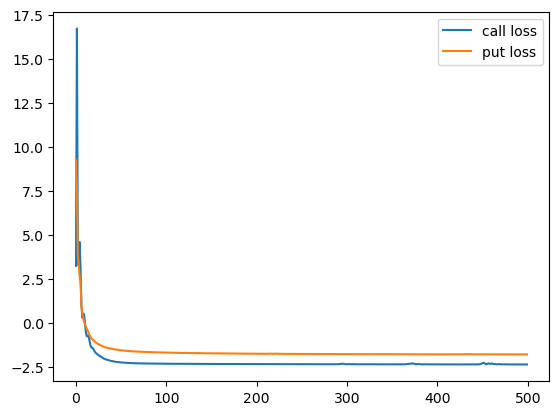

In [303]:
# plotting losses
c_plt_loss = gp_models[day_str]['call_losses']
p_plt_loss = gp_models[day_str]['put_losses']

plt.plot(range(len(c_plt_loss)), c_plt_loss, label='call loss')
plt.plot(range(len(p_plt_loss)), p_plt_loss, label='put loss')
plt.legend()
plt.show()

#### Plotting IV curve

In [304]:
rel_days = 0 # x days ago

# last trained model t_to_exp
t_to_exp = valid_ttm[0] + rel_days
#t_to_exp = 25

# getting training/test data
c_tr = gp_models[day_str]['call_train']
c_tst = gp_models[day_str]['call_test']
p_tr = gp_models[day_str]['put_train']
p_tst = gp_models[day_str]['put_test']


if modelnum!=3:
    c_tr = c_tr.loc[(c_tr['T']==t_to_exp) & (c_tr['rT']==rel_days)]
    c_tst = c_tst.loc[(c_tst['T']==t_to_exp)  & (c_tst['rT']==rel_days)]
    p_tr = p_tr.loc[(p_tr['T']==t_to_exp) & (p_tr['rT']==rel_days)]
    p_tst = p_tst.loc[(p_tst['T']==t_to_exp)  & (p_tst['rT']==rel_days)]
else:
    c_tr = c_tr[(c_tr['T']==t_to_exp)]
    c_tst = c_tst[(c_tst['T']==t_to_exp)]
    p_tr = p_tr[(p_tr['T']==t_to_exp)]
    p_tst = p_tst[(p_tst['T']==t_to_exp)]

# getting model/likelihood
c_plt_model = torch.load('models/TGP' + str(modelnum) + '_call_'+ day_str+'.pt')
c_plt_model.eval()
p_plt_model = torch.load('models/TGP' + str(modelnum) + '_put_' +day_str+'.pt')
p_plt_model.eval()
c_ll = gp_models[day_str]['call_likelihood']
c_ll.eval()
p_ll = gp_models[day_str]['put_likelihood']
p_ll.eval()

# sample data
rng_mny = np.array(np.linspace(0.7, 1.3, 100)).astype(np.float32)
samp_mny = (rng_mny - 0.7) / (1.3 - 0.7)
t_arr = np.array([t_to_exp]*100).astype(np.float32)
samp_t = (t_arr - 20) / (365 - 20)
if modelnum!=3:
    rT_arr = np.array([rel_days]*100).astype(np.float32)
    sample = torch.tensor([samp_t, samp_mny, rT_arr]).T #.reshape((1000, 2))
else:
    sample = torch.tensor([samp_t, samp_mny]).T

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    c_plt = c_ll(c_plt_model(sample))
    p_plt = p_ll(p_plt_model(sample))

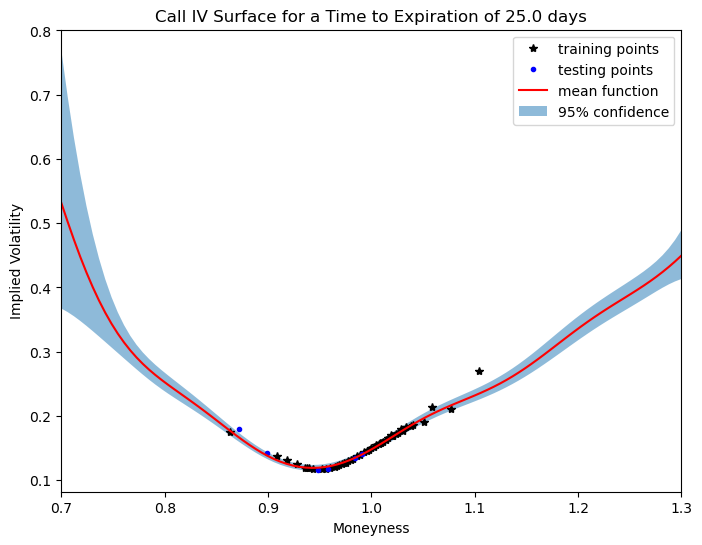

In [305]:
# calls
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(8, 6))

    # Get upper and lower confidence bounds
    lower, upper = c_plt.confidence_region()
    
    # Plot training data as black stars
    ax.plot(c_tr['mny'], c_tr['iv'], 'k*', label='training points')
    
    # Plot testing data as blue dots
    ax.plot(c_tst['mny'], c_tst['iv'], 'b.', label='testing points')
    
    # undo exponentiation
    lower = math.e ** lower.numpy() #np.log(lower.numpy())
    upper = math.e ** upper.numpy() #np.log(upper.numpy() ) 
    preds = math.e ** c_plt.mean.numpy() #np.log(c_plt.mean.numpy())
    
    # undo x-axis scaling by using rng_mny
    ax.plot(rng_mny, preds, 'r', label='mean function')
    
    # Shade between the lower and upper confidence bounds
    ax.fill_between(rng_mny, lower, upper, alpha=0.5, label='95% confidence')
    
    ax.set_xlim([0.7, 1.3])

    ax.set_xlabel("Moneyness")
    ax.set_ylabel("Implied Volatility")
    ax.set_title(f"Call IV Surface for a Time to Expiration of {t_to_exp} days")
    ax.legend()


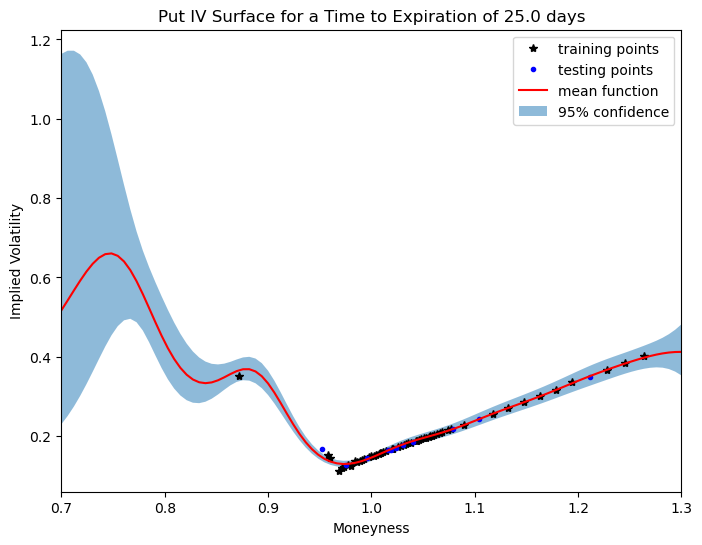

In [306]:
# puts
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(8, 6))

    # Get upper and lower confidence bounds
    lower, upper = p_plt.confidence_region()
    
    # Plot training data as black stars
    ax.plot(p_tr['mny'], p_tr['iv'], 'k*', label='training points')
    
    # plot test data as blue stars
    ax.plot(p_tst['mny'], p_tst['iv'], 'b.', label='testing points')
    
    # undo exponentiation
    lower = math.e ** lower.numpy() #np.log(lower.numpy())
    upper = math.e ** upper.numpy() #np.log(upper.numpy() ) 
    preds = math.e ** p_plt.mean.numpy() #np.log(p_plt.mean.numpy())
    
    # undo x-axis scaling by using original range
    ax.plot(rng_mny, preds, 'r', label='mean function')
    
    # Shade between the lower and upper confidence bounds
    ax.fill_between(rng_mny, lower, upper, alpha=0.5, label='95% confidence')
    
    ax.set_xlim([0.7, 1.3])
    ax.set_xlabel("Moneyness")
    ax.set_ylabel("Implied Volatility")
    ax.set_title(f"Put IV Surface for a Time to Expiration of {t_to_exp} days")

    ax.legend()


# IV SURFACE

In [307]:
c_surface = [] # coord (T, mny, iv)
p_surface = []

# getting model/likelihood
c_plt_model = torch.load('models/TGP' + str(modelnum) + '_call_' +day_str+'.pt')
c_plt_model.eval()
p_plt_model = torch.load('models/TGP' + str(modelnum) + '_put_' +day_str+'.pt')
p_plt_model.eval()
c_ll = gp_models[day_str]['call_likelihood']
c_ll.eval()
p_ll = gp_models[day_str]['put_likelihood']
p_ll.eval()

rng_mny = np.array(np.linspace(0.7, 1.3, 100)).astype(np.float32)
samp_mny = (rng_mny - 0.7) / (1.3 - 0.7)
samp_rt = np.array([-rel_days]*100).astype(np.float32)

for t_to_exp in valid_ttm:

    # getting training/test data
    #c_tr = gp_models[day_str]['call_train']
    #c_tr = c_tr.loc[c_tr['T']==t_to_exp]
    #c_tst = gp_models[day_str]['call_test']
    #c_tst = c_tst.loc[c_tst['T']==t_to_exp]

    #p_tr = gp_models[day_str]['put_train']
    #p_tr = p_tr.loc[p_tr['T']==t_to_exp]
    #p_tst = gp_models[day_str]['put_test']
    #p_tst = p_tst.loc[p_tst['T']==t_to_exp]

    # sample data
    t_arr = np.array([t_to_exp]*100).astype(np.float32)
    samp_t = (t_arr - 20) / (365 - 20)

    if modelnum!=3:
        sample = torch.tensor([samp_t, samp_mny, samp_rt]).T 
    else:
        sample = torch.tensor([samp_t, samp_mny]).T 


    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        c_plt = c_ll(c_plt_model(sample))
        p_plt = p_ll(p_plt_model(sample))
    
    # iv
    c_func = math.e ** c_plt.mean.numpy()
    p_func = math.e ** p_plt.mean.numpy()
    
    for i in range(100):
        c_surface.append([rng_mny[i], t_arr[i], c_func[i]])
        p_surface.append([rng_mny[i], t_arr[i], p_func[i]])
        
c_surface = np.array(c_surface)
p_surface = np.array(p_surface)

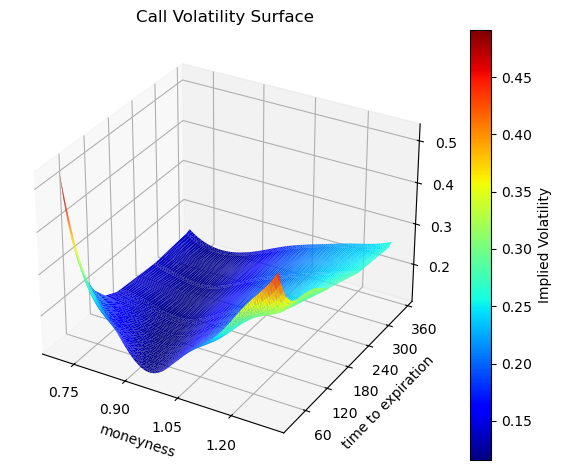

In [308]:
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

Xs = c_surface[:,0]
Ys = c_surface[:,1]
Zs = c_surface[:,2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(Xs, Ys, Zs, cmap=cm.jet, linewidth=0)
fig.colorbar(surf, label='Implied Volatility')

ax.set_xlabel('moneyness')
ax.set_ylabel('time to expiration')

ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.zaxis.set_major_locator(MaxNLocator(5))
ax.set_title('Call Volatility Surface')

fig.tight_layout()

plt.show() # or:

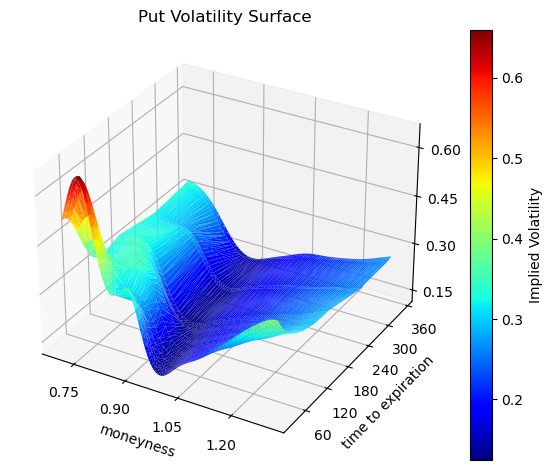

In [309]:
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

Xs = p_surface[:,0]
Ys = p_surface[:,1]
Zs = p_surface[:,2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(Xs, Ys, Zs, cmap=cm.jet, linewidth=0)
fig.colorbar(surf, label='Implied Volatility')

ax.set_xlabel('moneyness')
ax.set_ylabel('time to expiration')

ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.zaxis.set_major_locator(MaxNLocator(5))
ax.set_title('Put Volatility Surface')


fig.tight_layout()

plt.show() # or:

# RMSE 
put last bc long output

In [310]:
for day, info in gp_models.items():
    print(day)
    print('call: ', info['call_RMSE'].item())
    print('put: ', info['put_RMSE'].item())
    print()

2023-10-02
call:  0.002636590274050832
put:  0.010346784256398678

2023-10-03
call:  0.00700280861929059
put:  0.006869874894618988

2023-10-04
call:  0.003986000083386898
put:  0.006051409058272839

2023-10-05
call:  0.0023214006796479225
put:  0.005843548569828272

2023-10-06
call:  0.002392927650362253
put:  0.006539163179695606

2023-10-09
call:  0.002645085332915187
put:  0.003929533064365387

2023-10-10
call:  0.002558644860982895
put:  0.008855219930410385

2023-10-11
call:  0.0015787663869559765
put:  0.006178734358400106

2023-10-12
call:  0.002775590866804123
put:  0.004519907757639885

2023-10-13
call:  0.002556480700150132
put:  0.02207391895353794

2023-10-16
call:  0.0033859657123684883
put:  0.008763959631323814

2023-10-17
call:  0.0064856368117034435
put:  0.015120287425816059

2023-10-18
call:  0.003520914353430271
put:  0.008180719800293446

2023-10-19
call:  0.003762389300391078
put:  0.008731917478144169

2023-10-20
call:  0.0022598057985305786
put:  0.006292515434

In [313]:
c_rmse_arr = []
p_rmse_arr = []
for day in list(daily_chains.keys()):
    c_rmse_arr.append(gp_models[day]["call_RMSE"])
    p_rmse_arr.append(gp_models[day]["put_RMSE"])
    
print(f'mean call rmse: {np.array(c_rmse_arr).mean()}')
print(f'max call rmse: {np.array(c_rmse_arr).max()}')
print(f'min call rmse: {np.array(c_rmse_arr).min()}')
print()
print(f'mean put rmse: {np.array(p_rmse_arr).mean()}')
print(f'max put rmse: {np.array(p_rmse_arr).max()}')
print(f'min put rmse: {np.array(p_rmse_arr).min()}')


mean call rmse: 0.0032500289380550385
max call rmse: 0.00700280861929059
min call rmse: 0.0015787663869559765

mean put rmse: 0.009026735089719296
max put rmse: 0.02207391895353794
min put rmse: 0.003929533064365387


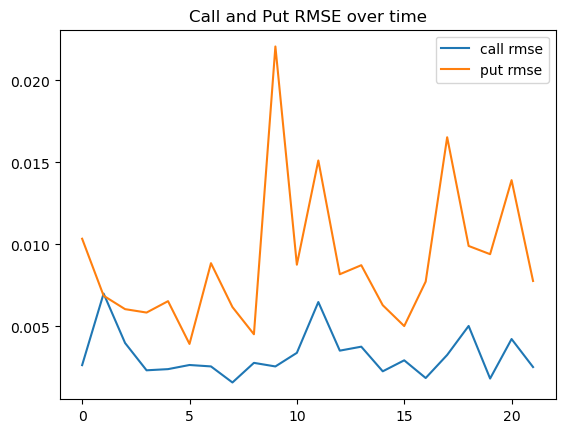

In [312]:
plt.plot(range(len(c_rmse_arr)), c_rmse_arr, label='call rmse')
plt.plot(range(len(p_rmse_arr)), p_rmse_arr, label='put rmse')

plt.title('Call and Put RMSE over time')
plt.legend()
plt.show()